In [ ]:
# Copyright 2021 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved.
# 
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of 6.S191 must
# reference:
#
# © MIT 6.S191: Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Libraries

In [ ]:
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1

In [ ]:
pip install sk-video

     |████████████████████████████████| 2.3MB 4.3MB/s 


In [ ]:
import gym

import tensorflow as tf
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import IPython, functools
from tqdm import tqdm
import cv2
from PIL import Image
import base64
import io
from IPython.display import HTML
from IPython import display as ipythondisplay

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Tennis env


### Install ROM

In [ ]:
!wget http://www.atarimania.com/roms/Roms.rar
!unrar x "/content/Roms.rar"
!unzip "/content/ROMS.zip"
!python -m atari_py.import_roms "/content/ROMS"

--2021-07-16 06:21:48--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   255KB/s    in 45s     

2021-07-16 06:22:33 (242 KB/s) - ‘Roms.rar’ saved [11128004/11128004]


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Roms.rar

Extracting  HC ROMS.zip                                                   36%  OK 
Extracting  ROMS.zip                                                      74% 99%  OK 
All OK
Archive:  /content/ROMS.zip
   creating: ROMS/
  inflating: ROMS/128 in 1 Game Select ROM (128 in 1) (Unknown) ~.bin  
  inflating: ROMS/2 Pak Special - Cavern Blaster, City War (1992) (HES) (773-867) 

### Env

In [ ]:
env = gym.make('Tennis-v0',frameskip = 4)

In [ ]:
def create_tennis_env():
  return gym.make('Tennis-v0',frameskip=4)

In [ ]:
n_actions = env.action_space.n

In [ ]:
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

In [ ]:
env.action_space

Discrete(18)

In [ ]:
env.unwrapped.get_action_meanings()

['NOOP',
 'FIRE',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'DOWNRIGHT',
 'DOWNLEFT',
 'UPFIRE',
 'RIGHTFIRE',
 'LEFTFIRE',
 'DOWNFIRE',
 'UPRIGHTFIRE',
 'UPLEFTFIRE',
 'DOWNRIGHTFIRE',
 'DOWNLEFTFIRE']

In [ ]:
env.seed(42)

[42, 742738649]

# Utilities

In [ ]:
## Play video mp4
def play_video(filename, width=None):
    encoded = base64.b64encode(io.open(filename, 'r+b').read())
    video_width = 'width="' + str(width) + '"' if width is not None else ''
    embedded = HTML(data='''
        <video controls {0}>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>'''.format(video_width, encoded.decode('ascii')))

    return embedded

In [ ]:
def save_video_of_model(model, env_name, suffix=""):
    import skvideo.io
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

    env = gym.make(env_name)
    obs = env.reset()
    prev_obs = obs

    filename = env_name + suffix + ".mp4"
    output_video = skvideo.io.FFmpegWriter(filename)

    counter = 0
    done = False
    while not done:
        frame = env.render(mode='rgb_array')
        output_video.writeFrame(frame)

        input_obs = frame_change(prev_obs, obs)

        action = model(np.expand_dims(input_obs, 0)).numpy().argmax()

        prev_obs = obs
        obs, reward, done, info = env.step(action)
        counter += 1

    output_video.close()
    print("Successfully saved {} frames into {}!".format(counter, filename))
    return filename

In [ ]:
def save_video_of_memory(memory, filename, size=(512,512)):
    import skvideo.io

    output_video = skvideo.io.FFmpegWriter(filename)

    for observation in memory.observations:
        output_video.writeFrame(cv2.resize(255*observation, size))
        
    output_video.close()
    return filename

In [ ]:
def display_model(model):
  tf.keras.utils.plot_model(model,
             to_file='tmp.png',
             show_shapes=True)
  return ipythondisplay.Image('tmp.png')


def plot_sample(x,y,vae):
    plt.figure(figsize=(2,1))
    plt.subplot(1, 2, 1)

    idx = np.where(y==1)[0][0]
    plt.imshow(x[idx])
    plt.grid(False)

    plt.subplot(1, 2, 2)
    _, _, _, recon = vae(x)
    recon = np.clip(recon, 0, 1)
    plt.imshow(recon[idx])
    plt.grid(False)

    plt.show()



class LossHistory:
  def __init__(self, smoothing_factor=0.0):
    self.alpha = smoothing_factor
    self.loss = []
  def append(self, value):
    self.loss.append( self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss)>0 else value )
  def get(self):
    return self.loss

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

# Process image

In [ ]:
# def preprocessing(image):
#     I = (image[:,:,0]*0.3) + (image[:,:,1]*0.59) + (image[:,:,2]*0.11)
#     I = I[20:190]
#     I = cv2.resize(I,(40,40))
#     return I
# def imgbuffer_process(imgbuffer, out_shape = (84, 84)):
#     img_list = []
#     for img in imgbuffer:
#         tmp = cv2.resize(src=img, dsize=out_shape)
#         tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
#         ## Need to convert data type to 32F
#         tmp = cv2.normalize(tmp, tmp, alpha=0.0, beta=1.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#         # Expand a dimension
#         tmp = np.expand_dims(tmp, len(tmp.shape))
#         img_list.append(tmp)
#     ret =  np.concatenate(tuple(img_list), axis=2)
#     #print('ret_shape = ' + str(ret.shape))
#     return ret

def preprocessing(image):
    # I = image[20:185,]
    # I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    # I = cv2.resize(I, (50,40))
    # I = I[:, 5:45]
    # return I.astype(np.float)
    I = image[25:185] # Crop
    I = I[::2, ::2, 0] # Downsample width and height by a factor of 2
    I[I == 82] = 0 # Remove background 
    I[I != 0] = 1 # Set remaining elements to 1
    I = cv2.dilate(I, np.ones((3, 3), np.uint8), iterations=1)
    I = I[::2, ::2, np.newaxis]
    return I.astype(np.float)


def frame_change(prev, curr):
    prev = preprocessing(prev)
    curr = preprocessing(curr)
    # diff = np.expand_dims(prev,-1) - np.expand_dims(curr,-1)
    diff = prev - curr
    return diff

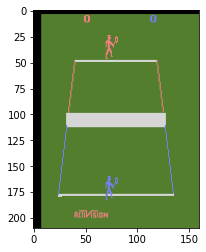

In [ ]:
observation = env.reset()
plt.imshow(observation)

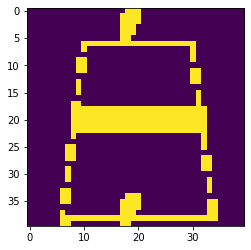

In [ ]:
new_observation = preprocessing(observation)
plt.imshow(np.squeeze(new_observation))

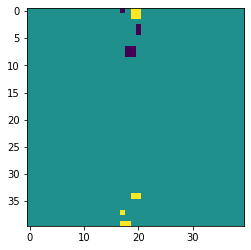

In [ ]:
next_observation, _,_,_ = env.step(np.random.choice(n_actions))
diff = frame_change(observation, next_observation)
plt.imshow(np.squeeze(diff))

# Agent Model

In [ ]:
Conv2D = functools.partial(tf.keras.layers.Conv2D, padding="same", activation="relu")
Flatten = tf.keras.layers.Flatten
Dense = tf.keras.layers.Dense

def create_tennis_model():
  model = tf.keras.models.Sequential([
                                      Conv2D(filters=32, kernel_size=5, strides=2),
                                      Conv2D(filters=48, kernel_size=5, strides=2),
                                      Conv2D(filters=64, kernel_size=3, strides=2),
                                      Conv2D(filters=64, kernel_size=3, strides=2),
                                      Flatten(),
                                      Dense(units=128,activation='relu'),
                                      Dense(units=n_actions)
  ])
  return model

tennis_model = create_tennis_model()

In [ ]:
# Define the agent's action function

def choose_action(model, observation, single=True, epsilon = 0.05):
  observation = np.expand_dims(observation, axis=0) if single else observation

  ### exploitation
  if np.random.random() <= epsilon:
    if single:
      action = np.random.randint(0, n_actions)
    else: 
      size = len(observation)
      action = np.random.randint(0,n_actions,size=size)
    return action

  else:
    ### exploration
    # feed the obsevations through the model to predict the log prob.
    logits = model.predict(observation)

    # choose action
    action = tf.random.categorical(logits,num_samples=1)

    action = action.numpy().flatten()

    return action[0] if single else action

# Reward function

In [ ]:
### Reward function ###

def normalize(x):
  x -= np.mean(x)
  x /= np.std(x)
  return x.astype(np.float32)
### Reward function ###

def discount_rewards(rewards, gamma=0.95):
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0,len(rewards))):
    if rewards[t] != 0:
      R=0
    R = R*gamma + rewards[t]
    discounted_rewards[t] = R
  return normalize(discounted_rewards)

# Memory 

In [ ]:
# Define agent's memory

## Agent memory ##
class Memory:
  def __init__(self):
    self.clear()
  
  def clear(self):
    '''reset/restart memory'''
    self.observations = []
    self.actions = []
    self.rewards = []
    
  def remove(self, num):
    self.observations = self.observations[num:-1]
    self.actions = self.actions[num:-1]
    self.rewards = self.rewards[num:-1]

  def add_to_memory(self, new_observation, new_action, new_reward):
    self.observations.append(new_observation)
    self.actions.append(new_action)
    self.rewards.append(new_reward)

def aggregate_memories(memories):
  batch_memory = Memory()

  for memory in memories:
    for step in zip(memory.observations,memory.actions,memory.rewards):
      batch_memory.add_to_memory(*step)
  return batch_memory

memory = Memory()

# Rollout

In [ ]:
### Rollout function ###

def collect_rollout(batch_size, env, model, choose_action):
  # Array for memory buffer
  memories = []

  # Process batch serially
  for b in range(batch_size):

    # Instantiate memory buffer, restart the environment
    memory = Memory()
    next_observation = env.reset()
    previous_frame = next_observation
    done = False

    while not done:
      current_frame = next_observation

      # observation change
      frame_diff = frame_change(previous_frame, current_frame)

      # choose an action
      action = choose_action(model, frame_diff)

      # take the chosen action
      next_observation, reward, done, info = env.step(action)

      # save the observed frame difference, the action that was taken, and the resulting reward!
      memory.add_to_memory(frame_diff, action, reward)

      previous_frame = current_frame
    
    memories.append(memory)

  return memories

In [ ]:
### Rollout with untrained tennis model ###

# Model
test_model = create_tennis_model()

# Rollout with single batch
single_batch_size = 1
memories = collect_rollout(single_batch_size, env, test_model, choose_action)
rollout_video = save_video_of_memory(memories[0], "Tennis-Random-Agent.mp4")

# # Play back video of memories
play_video(rollout_video)

# Loss

In [ ]:
### Loss function ###

# Arguments:
#   logits: network's predictions for actions to take
#   actions: the actions the agent took in an episode
#   rewards: the rewards the agent received in an episode
# Returns:
#   loss
def compute_loss(logits, actions, rewards): 
  '''compute the negative log probs'''
  neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(
     logits=logits, labels=actions)
  
  '''scale the negative log probability by the rewards'''
  loss = tf.reduce_mean(neg_logprob * rewards)
  
  return loss

# Hyperparameter

In [ ]:
### Hyperparameters and setup for training ###
# Rerun this cell if you want to re-initialize the training process
#   (i.e., create new model, reset loss, etc)

# Hyperparameters
learning_rate = 0.00025
MAX_ITERS = 1000 # increase the maximum to train longer
batch_size = 5 # number of batches to run

# Model, optimizer
tennis_model = create_tennis_model()
optimizer = tf.keras.optimizers.Adam(learning_rate)
iteration = 0 # counter for training steps
max_memory = 50000

# Plotting
smoothed_reward = LossHistory(smoothing_factor=0.9)
smoothed_reward.append(0) # start the reward at zero for baseline comparison
plotter = PeriodicPlotter(sec=15, xlabel='Iterations', ylabel='Win Percentage (%)')

# Batches and environment
# To parallelize batches, we need to make multiple copies of the environment.
envs = [create_tennis_env() for _ in range(batch_size)] # For parallelization

# training step

In [ ]:
### training step (forward and backward propagation) ###

def train_step(model, optimizer, observations, actions, discounted_rewards):
  with tf.GradientTape() as tape:
    ## forward prop
    logits = model(observations)

    loss = compute_loss(logits,actions,discounted_rewards)
  
  ## backward prop
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

# parallel rollout

In [ ]:
def parallelized_collect_rollout(batch_size, envs, model, choose_action):

    assert len(envs) == batch_size, "Number of parallel environments must be equal to the batch size."

    memories = [Memory() for _ in range(batch_size)]
    next_observations = [single_env.reset() for single_env in envs]
    previous_frames = [obs for obs in next_observations]
    done = [False] * batch_size
    rewards = [0] * batch_size

    while True:

        current_frames = [obs for obs in next_observations]
        diff_frames = [frame_change(prev, curr) for (prev, curr) in zip(previous_frames, current_frames)]

        diff_frames_not_done = [diff_frames[b] for b in range(batch_size) if not done[b]]
        actions_not_done = choose_action(model, np.array(diff_frames_not_done), single=False)

        actions = [None] * batch_size
        ind_not_done = 0
        for b in range(batch_size):
            if not done[b]:
                actions[b] = actions_not_done[ind_not_done]
                ind_not_done += 1

        for b in range(batch_size):
            if done[b]:
                continue
            next_observations[b], rewards[b], done[b], info = envs[b].step(actions[b])
            previous_frames[b] = current_frames[b]
            memories[b].add_to_memory(diff_frames[b], actions[b], rewards[b])

        if all(done):
            break

    return memories

# run

In [ ]:
path = '/gdrive/MyDrive/AI-Data/'

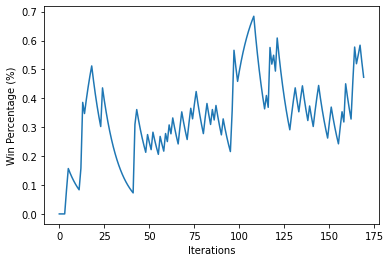

468.2542579174042


ResourceExhaustedError: ignored

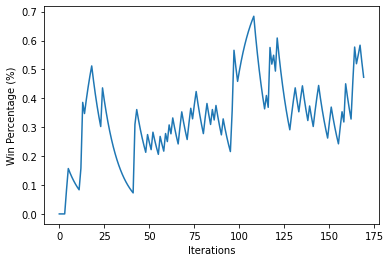

In [ ]:
games_to_win_episode = 21 # this is set by OpenAI gym and cannot be changed.

# Main training loop
while iteration < MAX_ITERS:

  plotter.plot(smoothed_reward.get())

  tic = time.time()
  # RL agent algorithm. By default, uses serial batch processing.
  # memories = collect_rollout(batch_size, env, tennis_model, choose_action)

  # Parallelized version. Uncomment line below (and comment out line above) to parallelize
  memories = parallelized_collect_rollout(batch_size, envs, tennis_model, choose_action)
  print(time.time()-tic)

  # Aggregate memories from multiple batches
  batch_memory = aggregate_memories(memories)

  # Track performance based on win percentage (calculated from rewards)
  total_wins = sum(np.array(batch_memory.rewards) == 1)
  total_games = sum(np.abs(np.array(batch_memory.rewards)))
  win_rate = total_wins / total_games
  smoothed_reward.append(100 * win_rate)
  
  # Training!
  train_step(
      tennis_model,
      optimizer,
      observations = np.stack(batch_memory.observations, 0),
      actions = np.array(batch_memory.actions),
      discounted_rewards = discount_rewards(batch_memory.rewards)
  )

  # Remove a bit memory when it reachs max_value
  if len(batch_memory.rewards) > max_memory:
    batch_memory.remove(len(batch_memory.rewards) - 30000)

  # Save a video of progress -- this can be played back later
  if iteration % 50 == 0:
    save_video_of_model(tennis_model,"Tennis-v0", suffix="_"+str(iteration))
    #save model
    tennis_model.save(path+'tennis_model'+str(iteration))
    rewards = pd.DataFrame(data=batch_memory.rewards,columns=['rewards'])
    obs = pd.DataFrame(data=batch_memory.observations,columns=['obs'])
    actions = pd.DataFrame(data=batch_memory.rewards,columns=['actions'])
    rewards.to_csv(path+'rewards'+str(iteration)+'.csv')
    obs.to_csv(path+'obs'+str(iteration)+'.csv')
    actions.to_csv(path+'action'+str(iteration)+'.csv')
    
  iteration += 1 # Mark next episode

In [ ]:
save_video_of_model(tennis_model,"Tennis-v0", suffix="_"+str(iteration))
#save model
tennis_model.save(path+'tennis_model'+str(iteration))
rewards = pd.DataFrame(data=batch_memory.rewards,columns=['rewards'])
rewards.to_csv(path+'rewards'+str(iteration)+'.csv')

Successfully saved 2031 frames into Tennis-v0_153.mp4!
INFO:tensorflow:Assets written to: /gdrive/MyDrive/AI-Data/tennis_model153/assets


#run1

In [ ]:
tennis_model_load = tf.keras.models.load_model('/gdrive/MyDrive/AI-Data/tennis_model153')

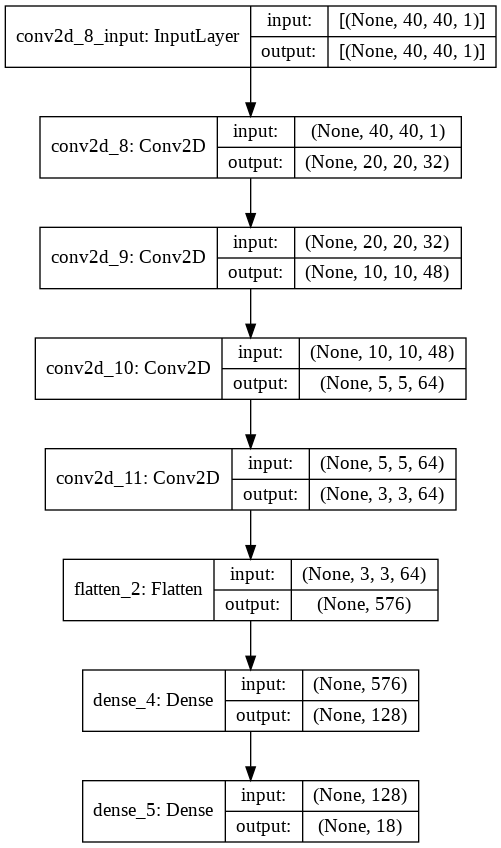

In [ ]:
display_model(tennis_model_load)

In [ ]:
save_video_of_model(tennis_model_load, 'Tennis-v0')

Successfully saved 1999 frames into Tennis-v0.mp4!


'Tennis-v0.mp4'

In [ ]:
play_video('/content/Tennis-v0.mp4')